# Kaggle Study 7일차(porto)

코드출처 : https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial

소개
이번 대회는 브라질에서 세 번째로 큰 보험회사 포르토 세구로(Porto Seguro)가 주최하며, 운전자가 내년 보험금 청구를 시작할 확률을 예측해야 하는 과제를 안고 있다.

이 노트북은 Python 시각화 라이브러리 Plot.ly을 통해 일부 대화형 차트 및 경쟁 데이터 분석을 제공하는 것을 목표로 하며, 다른 사람들이 가져와서 복제할 수 있는 몇 가지 통찰력과 아름다운 플롯을 제공할 수 있기를 바랍니다. Plot.ly은 소프트웨어 회사가 제공하는 주요 제품 중 하나이다. Plotly는 온라인 그래픽 및 통계 시각화(프로그래밍 및 대시보드)를 전문으로 제공하며 Python, R, Matlab, Node.js 등과 같은 풍부한 프로그래밍 언어 및 도구 모음에 API를 제공한다.

아래에는 이 노트북의 다양한 플롯 플롯에 대한 링크가 나와 있습니다.

- 단순 수평 막대 그림 - 목표 변수 분포를 검사하는 데 사용됩니다.
- 상관 관계 열 지도 그림 - 여러 특징 간의 상관 관계 검사
- 산점도 - 랜덤 포리스트와 그라데이션-부스트 모델에서 생성된 형상 중요도 비교
- 수직 막대 그림 - 다양한 형상의 중요도, 내림차순으로 나열
- 3D 산점도

이 노트북의 테마는 다음과 같이 간단히 요약할 수 있습니다.

1. 데이터 품질 검사 - 모든 결측/Null 값 시각화 및 평가(-1인 값)

2. 형상 검사 및 필터링 - 대상 변수에 대한 상관 및 형상 상호 정보 그림 이항, 범주형 및 기타 변수의 검사입니다.

3. 학습 모델을 통한 기능 중요도 순위 /n 랜덤 포레스트 및 그라데이션 부스트 모델을 구축하여 학습 프로세스에 따라 기능의 순위를 매기는 데 도움이 된다.

## 1회차

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

KeyboardInterrupt: 

In [ ]:
train = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/porto/train.csv')
train.head()

In [ ]:
rows = train.shape[0]
columns = train.shape[1]
print('The train dataset contains {0} rows and {1} columns'.format(rows,columns))

### 1. Data Quality checks

In [ ]:
train.isnull().any().any()

Null 값 검사에서는 False를 반환하지만, 이는 결측치 데이터가  -1로 등록되었기 때문이라고 추측을 하고 있다. 
여기서는 값에 -1이 포함된 열을 확인하여 예를 들어 다음과 같이 먼저 all -1을 null로 쉽게 대체해볼 것이다.

In [ ]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

다음으로, "Missingno" 패키지를 활용해 결측치를 확인해볼 것이다.

In [ ]:
import missingno as msno

msno.matrix(df=train_copy.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

빨간색 막대 위에 흰색 막대기(결측 데이터가 아닌 데이터)은 특정 열에 있는 데이터의 무효성을 반영한다. 이 예에서, 우리는 59개의 총 특징들 중 7개가 결측이 있다는 것을 확인할 수 있다. (실제로는 13개라고 한다.) 
관측할 수 있는 7개의 널(null) 열은 다음과 같이 여기에 나열됩니다.

ps_ind_05_cat | ps_reg_03 | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14


#### Target variable inspection

데이터에 대해 일반적으로 수행되는 또 다른 표준 검사는 대상 변수와 관련된 것으로, 이 경우 칼럼의 제목을 "target"이라고 편리하게 지정한다. 또한 목표값은 클래스/라벨/정답의 모니커에 의해 얻어지며, 이 학습된 기능이 일반화되고 잘 예측될 수 있기를 바라면서 데이터를 목표에 가장 잘 매핑하는 기능을 학습하기 위해 주어진 해당 데이터(우리의 경우 모든 열차 데이터)와 함께 지도 학습 모델에 사용됩니다.보이지 않는 새로운 데이터가 있습니다.

In [ ]:
data = [go.Bar(x = train["target"].value_counts().index.values,
               y = train["target"].value_counts().values,
               text='Distribution of target variable')]

layout = go.Layout(title='Target variable distribution')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

target이 다소 불균형하므로 유의해야 할 부분으로 보인다.

#### Datatype check

이 검사는 열차 세트가 어떤 종류의 데이터 유형으로 구성되어 있는지 확인하기 위해 수행된다. 파이썬 시퀀스에서 데이터 유형의 개수를 얻는 한 가지 방법은 다음과 같이 Counter 메소드를 사용할 수 있다.

In [ ]:
Counter(train.dtypes.values)

train 세트는 총 59개의 열이 있으며, 정수(int) 또는 실수(float)인 두 가지 데이터 유형만으로 구성된다.

또 다른 주목할 점은 포르투 세구로(Porto Seguro)가 실제로 "bin", "cat" 및 
"reg"와 같은 약어로 접미된 헤더를 우리에게 제공했다는 것이다. 여기서 그들은 bin은 이진 특징을 나타내고 나머지는 연속적 또는 순서적 특징이라는 대략적인 설명을 우리에게 주었다. 여기서는 부동 값(아마도 연속형만 해당)과 정수 데이터 유형(이항, 범주형 및 순서형 특징)을 살펴봄으로써 이것을 조금 더 단순화해야 한다.

In [ ]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

### Correlation plots

한 feature 가 다른 feature와 선형적으로 상관되어 있는지 간단히 살펴보기 위해 몇 가지 선형 상관 관계도를 seaborn을 가지고 그려본다. 

#### Correlation of float features

In [ ]:
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson corrlation of continuous features',y=1.05,size=15)
sns.heatmap(train_float.corr(),linewidth=0.1,vmax=1.0,square=True,
           cmap=colormap,linecolor='white',annot=True)

상관 그림을 보면 대부분의 형상이 서로 0 또는 상관 관계가 없다는 것을 알 수 있습니다. 현재는 양의 선형 상관 관계를 표시하는 쌍체 형상이 다음과 같이 나열됩니다.

- (ps_reg_01, ps_reg_03)
- (ps_reg_02, ps_reg_03)
- (ps_car_12, ps_car_13)
- (ps_car_13, ps_car_15)

#### Correlation of integer features

상관 데이터 유형의 열에 대해, 이제 Plotly 라이브러리를 사용하여 상호 작용적으로 상관 값의 열 지도를 생성하는 방법(히트맵)을 보여드리겠습니다. 여기서는 서로 다른 세 축에 값을 제공해야 합니다. 여기서 x축과 y축은 열 이름을 사용하고 상관 값은 z축에 의해 제공됩니다. 색 척도 속성은 열 지도에서 볼 수 있는 여러 색 팔레트에 해당하는 키워드를 포함하며, 이 예에서는 Greys 색 척도를 사용했습니다(다른 예로는 Portland 및 Viridis가 있습니다).

In [ ]:
data = [go.Heatmap(z= train_int.corr().values,
                   x=train_int.columns.values,
                   y=train_int.columns.values,
                   colorscale='Viridis',
                   reversescale = False,
                   #text = True ,
                   opacity = 1.0 )]

layout = go.Layout(title='Pearson Correlation of Integer-type features',
                  xaxis=dict(ticks='',nticks=36),
                  yaxis=dict(ticks=''),
                  width=900, height=700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='labelled-heatmap')

마찬가지로, 상관 관계도에서 0개의 값 셀을 꽤 많이 관찰된다. 따라서 서로 선형 상관 관계가 전혀 없는 많은 열이 있다는 것을 알 수 있다. 이는 특히 주성분 분석(PCA)과 같은 차원 축소 변환을 수행하려고 할 경우, 일정 수준의 상관 관계가 필요할 수 있으므로 우리에게 매우 유용한 관찰이다. 관심 있는 몇 가지 기능은 다음과 같습니다.

[음의 상관 관계가 있는 기능]
- ps_ind_06_bin
- ps_ind_07_bin
- ps_ind_08_bin
- ps_ind_09_bin

주목해야 할 흥미로운 측면 중 하나는 Nullity에 대한 이전의 분석에서 ps_car_03_cat 과 ps_car_05_cat이 많은 결측값 또는 null 값을 포함하는 것으로 확인되었다는 것이다. 

따라서 데이터의 기본 진리를 실제로 반영하지는 않을 수 있지만 이러한 두 특징이 이 기준에서 서로에 대해 상당히 강한 양의 선형 상관관계를 보인다는 것은 놀랄 일이 아니다.  

### Mutual Information plots

상호 정보는 대상 변수와 그것이 계산되는 해당 기능 사이의 상호 정보를 검사할 수 있기 때문에 또 다른 유용한 도구이다.   
  
분류 문제의 경우, 우리는 두 랜덤 변수 사이의 종속성을 측정하는 Sklearn의 mutual_info_classif 방법을 편리하게 호출할 수 있으며, 이 방법은 랜덤 변수가 서로 독립적인 0에서 높은 값(일부 종속성을 나타냄)까지이다. 따라서 대상 정보가 기능 내에 얼마나 포함될 수 있는지 알 수 있다.  
  
mutual_info_classif 함수의 sklearn 구현은 "k-최근접 이웃을 기반으로 하는 비모수 방법에 의존한다"고 알려준다. 여기서 여기 링크의 공식 sklearn 페이지에서 더 자세히 살펴볼 수 있다.

In [ ]:
mf = mutual_info_classif(train_float.values,train.target.values,n_neighbors=3,random_state=17)
print(mf)

### Binary features inspection

이번엔 이진수 값만 포함하는 열(즉, 값이 두 값 1 또는 0 중 하나만 갖는 경우)을 분석해보겠다. 이러한 이항 값이 포함된 모든 열을 저장한 다음, 그래프를 그려보자.

In [ ]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [ ]:
trace1 = go.Bar(x=bin_col,y=zero_list,name='Zero count')
trace2 = go.Bar(x=bin_col,y=one_list,name='One count')

data = [trace1,trace2]
layout = go.Layout(barmode='stack',title='Count of 1 and 0 in binary variables')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='stacked-bar')

여기서 우리는 0이 대부분을 차지하는 4가지 특성, ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin이 있다는 것을 확인할 수 있다. 이는 이러한 기능이 대상에 대한 다른 클래스에 대한 많은 정보를 포함하지 않기 때문에 유용한지 여부에 대한 의문을 제기한다.

### Categorical and Ordinal feature inspection

먼저 접미사 "cat"에 따라 범주형이라고 하는 기능에 대해 살펴보겠습니다.

### Feature importance via Random Forest

이제 랜덤 포레스트 분류기로 교육 데이터를 적합시키고, 모델이 교육을 마친 후 기능의 순위를 살펴보는 랜덤 포레스트 모델을 구현해 보자. 이것은 유용한 기능 중요성을 얻는 데 매개 변수 튜닝이 많이 필요하지 않고 목표 불균형을 위해 매우 강력한 앙상블 모델(Bootboot 집계 아래에 적용된 약한 의사 결정 트리 학습자의 앙상블)을 빠르게 사용하는 방법이다.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150,max_depth=8,min_samples_leaf=4,
                            max_features=0.2,n_jobs=-1,random_state=0)
rf.fit(train.drop(['id','target'],axis=1),train.target)
features = train.drop(['id','target'],axis=1).columns.values
print('-----Training Done-----')

#### Plot.ly Scatter Plot of feature importances

랜덤 포리스트를 교육한 후에는 "특징 중요도" 특성을 호출하여 형상 중요도 목록을 얻고 다음 플롯 그림인 산점도 그림을 그릴 수 있습니다.

여기서는 분산 명령을 호출하고 이전 플롯 그림에 따라 y축과 x축을 정의해야 합니다. 그러나 산점도에서 주목해야 하는 한 가지는 marker 속성입니다. 이것은 내장된 산점들의 크기, 색상 및 스케일을 정의하고 이에 따라 제어하는 마커 속성이다.

In [ ]:
trace = go.Scatter(y=rf.feature_importances_,x=features,mode='markers',
                  marker=dict(sizemode='diameter',sizeref=1,size=13,
                              color=rf.feature_importances_,colorscale='Portland',
                             showscale=True),
                  text=features)
data=[trace]

layout=go.Layout(autosize=True, title='Random Forest Feature Importance',hovermode='closest',
                 xaxis=dict(ticklen=5,showgrid=False,zeroline=False,showline=False),
                yaxis=dict(title='Feature Importance',showgrid=False,zeroline=False,ticklen=5,gridwidth=2),
                showlegend=False)
fig=go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')

또한 다음과 같은 막대 그래프를 통해 중요도 순으로 순위가 매겨진 모든 피쳐의 목록을 정렬하여 표시할 수 있습니다.

In [ ]:
x,y=(list(x)for x in zip(*sorted(zip(rf.feature_importances_,features),reverse=False)))

trace2 = go.Bar(x=x,y=y,
                marker=dict(color=x,colorscale='Viridis',reversescale=True),
                name='Random Forest Feature importance',orientation='h'
               )
layout=dict(title='Barplot of Feature importances', width=900,height=2000,
           yaxis=dict(showgrid=False,showline=False,showticklabels=True))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1,filename='plots')

#### Decision Tree visualisation
또 다른 기법은 모델에 의해 만들어진 나뭇가지나 결정을 시각화하는 것이다. 단순성을 위해 의사 결정 트리(max_depth = 3)에 적합하므로 의사 결정 분기에 3개의 수준만 표시되므로 sklearn "export_graphviz"에서 내보내기를 사용하여 시각화 속성을 그래프로 표시한 다음 이 노트북에서 시각화를 위해 트리 이미지를 내보내고 가져옵니다.

In [ ]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image,ImageDraw,ImageFont
import re

decision_tree= tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(train.drop(['id', 'target'],axis=1), train.target)

with open("tree1.dot",'w') as f:
    f = tree.export_graphviz(decision_tree,out_file=f,max_depth=4,impurity=False,
                            feature_names=train.drop(['id','target'],axis=1).columns.values,
                            class_names=['No','Yes'],rounded=True,filled=True)
    
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

img=Image.open("tree1.png")
draw=ImageDraw.Draw(img)
img.save('sample-out.png')
PImage('sample-out.png',)

### Feature importance via Gradient Boosting model

이번에는 Gradient Boosting 분류기를 사용하여 교육 데이터에 적합하게 한다. Gradient Boosting은 전진 단계 방식으로 진행되며, 각 단계에서는 손실 함수의 그레이디언트(Sklearn 구현의 이탈로 기본 설정됨)에 대한 회귀 응력이 장착된다.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

In [ ]:
trace = go.Scatter(y=gb.feature_importances_,x=features,mode='markers',
                  marker=dict(sizemode='diameter',sizeref=1,size=13,
                              color=gb.feature_importances_,colorscale='Portland',
                             showscale=True),
                  text=features)
data=[trace]

layout=go.Layout(autosize=True, title='Gradient Boosting Machine Feature Importance',hovermode='closest',
                 xaxis=dict(ticklen=5,showgrid=False,zeroline=False,showline=False),
                yaxis=dict(title='Feature Importance',showgrid=False,zeroline=False,ticklen=5,gridwidth=2),
                showlegend=False)
fig=go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')

In [ ]:
x,y=(list(x)for x in zip(*sorted(zip(gb.feature_importances_,features),reverse=False)))

trace2 = go.Bar(x=x,y=y,
                marker=dict(color=x,colorscale='Viridis',reversescale=True),
                name='Gradient Boosting Classifier Feature importance',orientation='h'
               )
layout=dict(title='Barplot of Feature importances', width=900,height=2000,
           yaxis=dict(showgrid=False,showline=False,showticklabels=True))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1,filename='plots')

흥미롭게도 우리는 랜덤 포레스트와 그라데이션 부스트 학습 모델 모두에서 두 모델이 선택한 가장 중요한 기능은 열:ps_car_13이라는 것을 관찰한다.

이 특정 기능은 추가 조사를 보증하므로 심층 분석을 수행하겠습니다.

### Conclusion

우리는 Null 값과 데이터 품질을 검사하고, 특징 간의 선형 상관 관계를 조사하며, 특징 분포의 일부를 검사하고, 두 가지 학습 모델(Random Forest 및 Gradient Boosting classifier)을 구현하여 Porto Seguro 데이터 세트에 대해 상당히 광범위한 검사를 수행했다.

## 2회차

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/porto/train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
rows = train.shape[0]
columns - train.shape[1]
print('The train dataset contains {0} rows and {1} columns'.format(rows,columns))

NameError: name 'columns' is not defined

### 1. Data Quality checks

In [6]:
train.isnull().any().any()

False

Null 값 검사에서는 False를 반환하지만, 이는 결측치 데이터가  -1로 등록되었기 때문이라고 추측을 하고 있다. 
여기서는 값에 -1이 포함된 열을 확인하여 예를 들어 다음과 같이 먼저 all -1을 null로 쉽게 대체해볼 것이다.

In [7]:
train_copy = train
train_copy = train_copy.replace(-1,np.NaN)

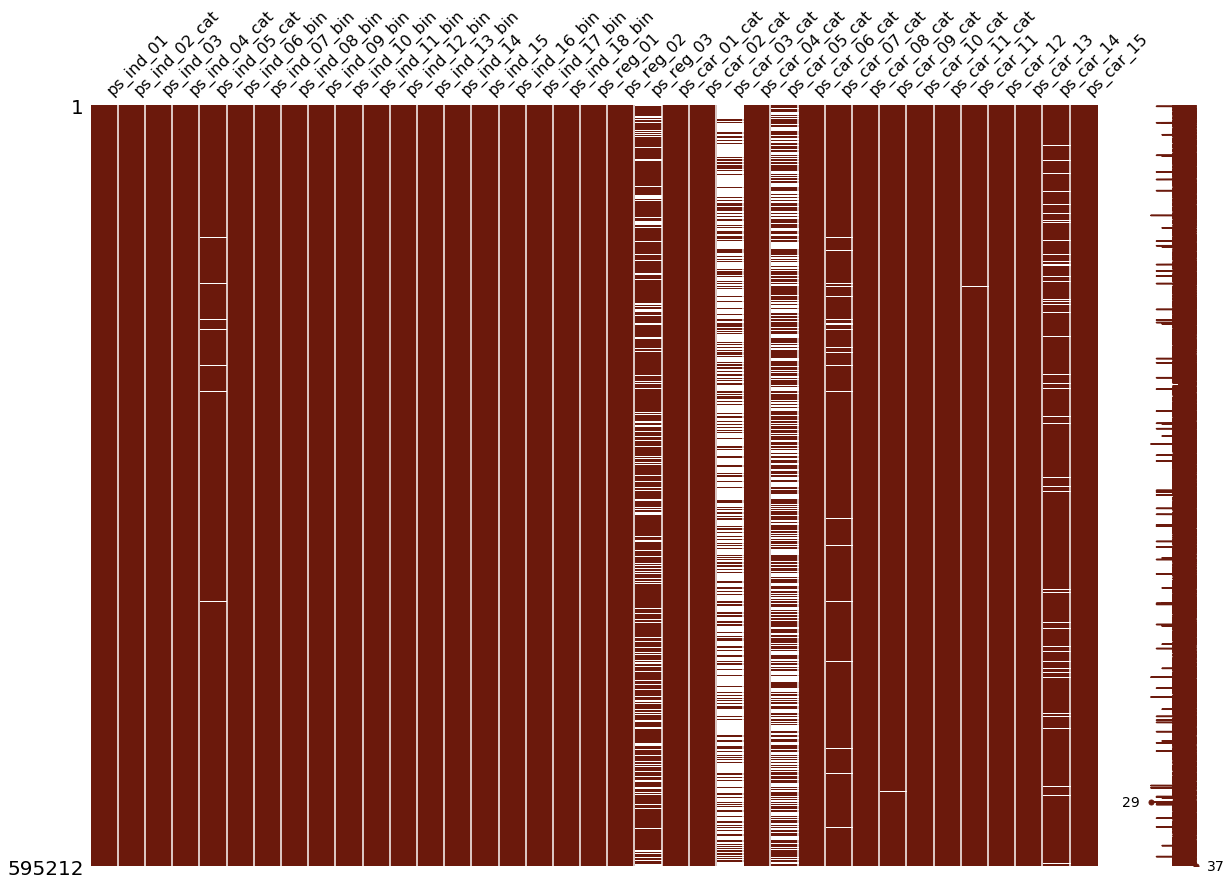

In [8]:
import missingno as msno

msno.matrix(df=train_copy.iloc[:,2:39],figsize=(20,14),color=(0.42,0.1,0.05))

빨간색 막대 위에 흰색 막대기(결측 데이터가 아닌 데이터)은 특정 열에 있는 데이터의 무효성을 반영한다. 이 예에서, 우리는 59개의 총 특징들 중 7개가 결측이 있다는 것을 확인할 수 있다. (실제로는 13개라고 한다.) 
관측할 수 있는 7개의 널(null) 열은 다음과 같이 여기에 나열됩니다.

ps_ind_05_cat | ps_reg_03 | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14


#### Target variable inspection

데이터에 대해 일반적으로 수행되는 또 다른 표준 검사는 대상 변수와 관련된 것으로, 이 경우 칼럼의 제목을 "target"이라고 편리하게 지정한다. 또한 목표값은 클래스/라벨/정답의 모니커에 의해 얻어지며, 이 학습된 기능이 일반화되고 잘 예측될 수 있기를 바라면서 데이터를 목표에 가장 잘 매핑하는 기능을 학습하기 위해 주어진 해당 데이터(우리의 경우 모든 열차 데이터)와 함께 지도 학습 모델에 사용됩니다.보이지 않는 새로운 데이터가 있습니다.

In [9]:
data = [go.Bar(x = train["target"].value_counts().index.values,
               y = train["target"].value_counts().values,
               text='Distribution of target variable')]

layout = go.Layout(title='Target variable distribution')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

target이 다소 불균형하므로 유의해야 할 부분으로 보인다.

#### Datatype check

이 검사는 열차 세트가 어떤 종류의 데이터 유형으로 구성되어 있는지 확인하기 위해 수행된다. 파이썬 시퀀스에서 데이터 유형의 개수를 얻는 한 가지 방법은 다음과 같이 Counter 메소드를 사용할 수 있다.

In [10]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

train 세트는 총 59개의 열이 있으며, 정수(int) 또는 실수(float)인 두 가지 데이터 유형만으로 구성된다.

또 다른 주목할 점은 포르투 세구로(Porto Seguro)가 실제로 "bin", "cat" 및 
"reg"와 같은 약어로 접미된 헤더를 우리에게 제공했다는 것이다. 여기서 그들은 bin은 이진 특징을 나타내고 나머지는 연속적 또는 순서적 특징이라는 대략적인 설명을 우리에게 주었다. 여기서는 부동 값(아마도 연속형만 해당)과 정수 데이터 유형(이항, 범주형 및 순서형 특징)을 살펴봄으로써 이것을 조금 더 단순화해야 한다.

In [11]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

### Correlation plots

한 feature 가 다른 feature와 선형적으로 상관되어 있는지 간단히 살펴보기 위해 몇 가지 선형 상관 관계도를 seaborn을 가지고 그려본다. 

#### Correlation of float features

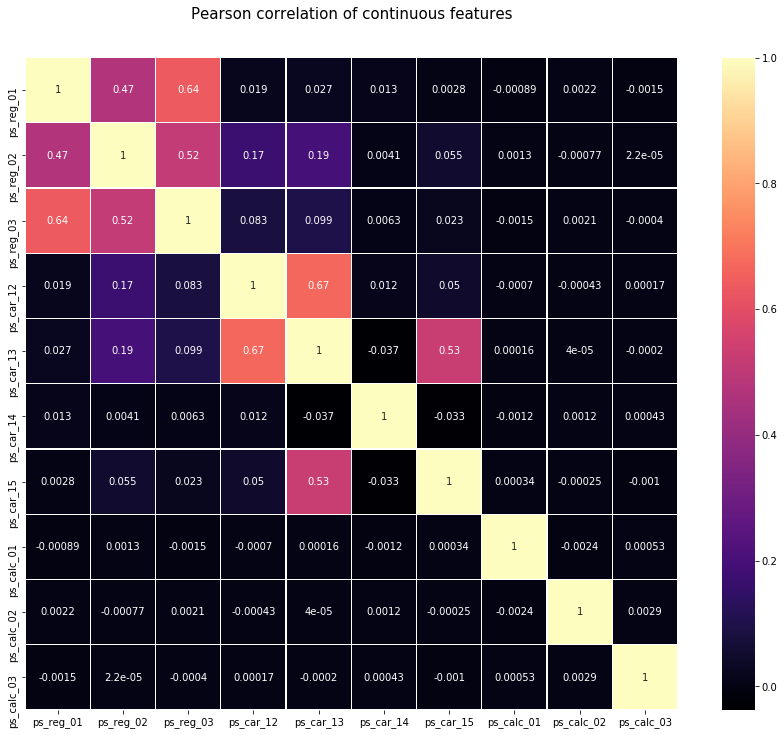

In [12]:
colormap=plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features',y=1.05,size=15)
sns.heatmap(train_float.corr(),linewidth=0.1,vmax=1.0,square=True,
           cmap=colormap,linecolor='white',annot=True)

상관 그림을 보면 대부분의 형상이 서로 0 또는 상관 관계가 없다는 것을 알 수 있습니다. 현재는 양의 선형 상관 관계를 표시하는 쌍체 형상이 다음과 같이 나열됩니다.

- (ps_reg_01, ps_reg_03)
- (ps_reg_02, ps_reg_03)
- (ps_car_12, ps_car_13)
- (ps_car_13, ps_car_15)

#### Correlation of integer features

상관 데이터 유형의 열에 대해, 이제 Plotly 라이브러리를 사용하여 상호 작용적으로 상관 값의 열 지도를 생성하는 방법(히트맵)을 보여드리겠습니다. 여기서는 서로 다른 세 축에 값을 제공해야 합니다. 여기서 x축과 y축은 열 이름을 사용하고 상관 값은 z축에 의해 제공됩니다. 색 척도 속성은 열 지도에서 볼 수 있는 여러 색 팔레트에 해당하는 키워드를 포함하며, 이 예에서는 Greys 색 척도를 사용했습니다(다른 예로는 Portland 및 Viridis가 있습니다).

In [13]:
data = [go.Heatmap(z=train_int.corr().values,
                  x=train_int.columns.values,
                  y=train_int.columns.values,
                  colorscale='Viridis',
                  reversescale=False,
                  opacity=1.0)]

layout = go.Layout(title="Pearson Correlation of Integer-type features",
                  xaxis=dict(ticks='',nticks=36),
                  yaxis=dict(ticks=''),
                  width=900,height=700)

fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='labelled-heatmap')

마찬가지로, 상관 관계도에서 0개의 값 셀을 꽤 많이 관찰된다. 따라서 서로 선형 상관 관계가 전혀 없는 많은 열이 있다는 것을 알 수 있다. 이는 특히 주성분 분석(PCA)과 같은 차원 축소 변환을 수행하려고 할 경우, 일정 수준의 상관 관계가 필요할 수 있으므로 우리에게 매우 유용한 관찰이다. 관심 있는 몇 가지 기능은 다음과 같습니다.

[음의 상관 관계가 있는 기능]
- ps_ind_06_bin
- ps_ind_07_bin
- ps_ind_08_bin
- ps_ind_09_bin

주목해야 할 흥미로운 측면 중 하나는 Nullity에 대한 이전의 분석에서 ps_car_03_cat 과 ps_car_05_cat이 많은 결측값 또는 null 값을 포함하는 것으로 확인되었다는 것이다. 

따라서 데이터의 기본 진리를 실제로 반영하지는 않을 수 있지만 이러한 두 특징이 이 기준에서 서로에 대해 상당히 강한 양의 선형 상관관계를 보인다는 것은 놀랄 일이 아니다.  

### Mutual Information plots

상호 정보는 대상 변수와 그것이 계산되는 해당 기능 사이의 상호 정보를 검사할 수 있기 때문에 또 다른 유용한 도구이다.   
  
분류 문제의 경우, 우리는 두 랜덤 변수 사이의 종속성을 측정하는 Sklearn의 mutual_info_classif 방법을 편리하게 호출할 수 있으며, 이 방법은 랜덤 변수가 서로 독립적인 0에서 높은 값(일부 종속성을 나타냄)까지이다. 따라서 대상 정보가 기능 내에 얼마나 포함될 수 있는지 알 수 있다.  
  
mutual_info_classif 함수의 sklearn 구현은 "k-최근접 이웃을 기반으로 하는 비모수 방법에 의존한다"고 알려준다. 여기서 여기 링크의 공식 sklearn 페이지에서 더 자세히 살펴볼 수 있다.

In [14]:
mf=mutual_info_classif(train_float.values,train.target.values,n_neighbors=3,random_state=17)
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


### Binary features inspection

이번엔 이진수 값만 포함하는 열(즉, 값이 두 값 1 또는 0 중 하나만 갖는 경우)을 분석해보겠다. 이러한 이항 값이 포함된 모든 열을 저장한 다음, 그래프를 그려보자.

In [15]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==0).sum())

In [16]:
trace1 = go.Bar(x=bin_col,y=zero_list,name='Zero count')
trace2 = go.Bar(x=bin_col,y=one_list,name='One count')

data = [trace1,trace2]
layout = go.Layout(barmode='stack',title='Count of 1 and 0 in binary variables')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='stacked-bar')

여기서 우리는 0이 대부분을 차지하는 4가지 특성, ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin이 있다는 것을 확인할 수 있다. 이는 이러한 기능이 대상에 대한 다른 클래스에 대한 많은 정보를 포함하지 않기 때문에 유용한지 여부에 대한 의문을 제기한다.

### Categorical and Ordinal feature inspection

먼저 접미사 "cat"에 따라 범주형이라고 하는 기능에 대해 살펴보겠습니다.

### Feature importance via Random Forest

이제 랜덤 포레스트 분류기로 교육 데이터를 적합시키고, 모델이 교육을 마친 후 기능의 순위를 살펴보는 랜덤 포레스트 모델을 구현해 보자. 이것은 유용한 기능 중요성을 얻는 데 매개 변수 튜닝이 많이 필요하지 않고 목표 불균형을 위해 매우 강력한 앙상블 모델(Bootboot 집계 아래에 적용된 약한 의사 결정 트리 학습자의 앙상블)을 빠르게 사용하는 방법이다.

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150,max_depth=8,min_samples_leaf=4,
                            max_features=0.2,n_jobs=-1,random_state=0)
rf.fit(train.drop(['id','target'],axis=1),train.target)
features = train.drop(['id','target'],axis=1).columns.values
print('-----Training Done-----')

-----Training Done-----


#### Plot.ly Scatter Plot of feature importances

랜덤 포리스트를 교육한 후에는 "특징 중요도" 특성을 호출하여 형상 중요도 목록을 얻고 다음 플롯 그림인 산점도 그림을 그릴 수 있습니다.

여기서는 분산 명령을 호출하고 이전 플롯 그림에 따라 y축과 x축을 정의해야 합니다. 그러나 산점도에서 주목해야 하는 한 가지는 marker 속성입니다. 이것은 내장된 산점들의 크기, 색상 및 스케일을 정의하고 이에 따라 제어하는 마커 속성이다.

In [18]:
trace = go.Scatter(y=rf.feature_importances_,x=features,mode='markers',
                  marker=dict(sizemode='diameter',sizeref=1,size=13,
                              color=rf.feature_importances_,colorscale='Portland',
                             showscale=True),
                  text=features)
data=[trace]

layout=go.Layout(autosize=True, title='Random Forest Feature Importance',hovermode='closest',
                 xaxis=dict(ticklen=5,showgrid=False,zeroline=False,showline=False),
                yaxis=dict(title='Feature Importance',showgrid=False,zeroline=False,ticklen=5,gridwidth=2),
                showlegend=False)
fig=go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')

또한 다음과 같은 막대 그래프를 통해 중요도 순으로 순위가 매겨진 모든 피쳐의 목록을 정렬하여 표시할 수 있습니다.

In [19]:
x,y=(list(x)for x in zip(*sorted(zip(rf.feature_importances_,features),reverse=False)))

trace2 = go.Bar(x=x,y=y,
                marker=dict(color=x,colorscale='Viridis',reversescale=True),
                name='Random Forest Feature importance',orientation='h'
               )
layout=dict(title='Barplot of Feature importances', width=900,height=2000,
           yaxis=dict(showgrid=False,showline=False,showticklabels=True))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1,filename='plots')

#### Decision Tree visualisation
또 다른 기법은 모델에 의해 만들어진 나뭇가지나 결정을 시각화하는 것이다. 단순성을 위해 의사 결정 트리(max_depth = 3)에 적합하므로 의사 결정 분기에 3개의 수준만 표시되므로 sklearn "export_graphviz"에서 내보내기를 사용하여 시각화 속성을 그래프로 표시한 다음 이 노트북에서 시각화를 위해 트리 이미지를 내보내고 가져옵니다.

In [ ]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image,ImageDraw,ImageFont
import re

decision_tree= tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(train.drop(['id', 'target'],axis=1), train.target)

with open("tree1.dot",'w') as f:
    f = tree.export_graphviz(decision_tree,out_file=f,max_depth=4,impurity=False,
                            feature_names=train.drop(['id','target'],axis=1).columns.values,
                            class_names=['No','Yes'],rounded=True,filled=True)
    
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

img=Image.open("tree1.png")
draw=ImageDraw.Draw(img)
img.save('sample-out.png')
PImage('sample-out.png',)

### Feature importance via Gradient Boosting model

이번에는 Gradient Boosting 분류기를 사용하여 교육 데이터에 적합하게 한다. Gradient Boosting은 전진 단계 방식으로 진행되며, 각 단계에서는 손실 함수의 그레이디언트(Sklearn 구현의 이탈로 기본 설정됨)에 대한 회귀 응력이 장착된다.

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [21]:
trace = go.Scatter(y=gb.feature_importances_,x=features,mode='markers',
                  marker=dict(sizemode='diameter',sizeref=1,size=13,
                              color=gb.feature_importances_,colorscale='Portland',
                             showscale=True),
                  text=features)
data=[trace]

layout=go.Layout(autosize=True, title='Gradient Boosting Machine Feature Importance',hovermode='closest',
                 xaxis=dict(ticklen=5,showgrid=False,zeroline=False,showline=False),
                yaxis=dict(title='Feature Importance',showgrid=False,zeroline=False,ticklen=5,gridwidth=2),
                showlegend=False)
fig=go.Figure(data=data,layout=layout)
py.iplot(fig,filename='scatter2010')

In [22]:
x,y=(list(x)for x in zip(*sorted(zip(gb.feature_importances_,features),reverse=False)))

trace2 = go.Bar(x=x,y=y,
                marker=dict(color=x,colorscale='Viridis',reversescale=True),
                name='Gradient Boosting Classifier Feature importance',orientation='h'
               )
layout=dict(title='Barplot of Feature importances', width=900,height=2000,
           yaxis=dict(showgrid=False,showline=False,showticklabels=True))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1,filename='plots')

흥미롭게도 우리는 랜덤 포레스트와 그라데이션 부스트 학습 모델 모두에서 두 모델이 선택한 가장 중요한 기능은 열:ps_car_13이라는 것을 관찰한다.

이 특정 기능은 추가 조사를 보증하므로 심층 분석을 수행하겠습니다.

### Conclusion

우리는 Null 값과 데이터 품질을 검사하고, 특징 간의 선형 상관 관계를 조사하며, 특징 분포의 일부를 검사하고, 두 가지 학습 모델(Random Forest 및 Gradient Boosting classifier)을 구현하여 Porto Seguro 데이터 세트에 대해 상당히 광범위한 검사를 수행했다.